# Time comparison for synology vs Nemo


In [3]:
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm
import pandas as pd

In [ ]:
def update_slider(event):
    # only trigger if update comes from first axis (optional)
        #ind_lambda = viewer.dims.indices[0]
    time = viewer.dims.current_step[0]
    viewer.text_overlay.text = f"{time:1.1f} hours"
text_size = 24
napari_scale = [1.4949402023919043e-07, 1.4949402023919043e-07]


label_text_size = 15
### glimpse size
size = 500
### resized images are to this scale
scale = 6048/1200

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [4]:
%%time
expt_ID = 'ND0002'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
# metadata_fn = '/mnt/SYNO/macrohet_syno/ND0001/acquisition/ND0001__2023-10-27T14_12_54-Measurement 1/Images/Index.idx.xml'#glob.glob(os.path.join(base_dir, 'Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
# temporary hack to fix URL from incorrectly exported metadata
# metadata['URL'] = metadata.apply(dataio.generate_url, axis=1)
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 36.4 s, sys: 3.48 s, total: 39.9 s
Wall time: 41.5 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [5]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Define row and column of choice

In [6]:
acq_ID = row, column = (3, 4)

### Define subset if non-square tiling or more than one contiguous region of images in imaging well. 

In [5]:
# subset_field_IDs = ['1','6','7','8','11','12','13','14','15']

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [9]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

CPU times: user 881 ms, sys: 2.99 ms, total: 884 ms
Wall time: 880 ms


dask.array<reshape, shape=(150, 2, 1, 6048, 6048), dtype=uint16, chunksize=(1, 2, 1, 2160, 2160), chunktype=numpy.ndarray>

In [101]:
%%time 
### this is NEMO
images = images.compute().compute()

CPU times: user 6h 36min 7s, sys: 49min 7s, total: 7h 25min 14s
Wall time: 53min 52s


In [125]:
%%time 
### this is SYNO
images = images.compute().compute()

CPU times: user 6h 29min 13s, sys: 48min 21s, total: 7h 17min 35s
Wall time: 29min 14s


In [10]:
%%time 
### this is SYNO 1 plane
images = images.compute().compute()

CPU times: user 2h 17min 6s, sys: 15min 2s, total: 2h 32min 9s
Wall time: 7min 18s


In [14]:
images_1plane = images

In [11]:
images.shape

(150, 2, 1, 6048, 6048)

In [15]:
viewer.title = '1 plane'

In [24]:
viewer = napari.Viewer(title = f'{expt_ID} 1 plane vis with tracks')

viewer.add_image(images, channel_axis = 1, scale = napari_scale, contrast_limits=[[280, 1000],[0,3000]])
# viewer.theme = 'light'
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'm'
viewer.scale_bar.font_size = text_size
viewer.text_overlay.visible = True
viewer.text_overlay.color = 'white'
viewer.text_overlay.position = 'bottom_left'
viewer.text_overlay.font_size = text_size
viewer.dims.events.current_step.connect(update_slider)

<function __main__.update_slider(event)>

In [26]:
from napari_animation import Animation

animation = Animation(viewer)

viewer.dims.ndisplay = 3
viewer.camera.angles = (0.0, 0.0, 90.0)
animation.capture_keyframe()
viewer.camera.zoom = 2.4
animation.capture_keyframe()
viewer.camera.angles = (-7.0, 15.7, 62.4)
animation.capture_keyframe(steps=60)
viewer.camera.angles = (2.0, -24.4, -36.7)
animation.capture_keyframe(steps=60)
viewer.reset_view()
viewer.camera.angles = (0.0, 0.0, 90.0)
animation.capture_keyframe()
animation.animate('demo.mov', canvas_only=False)


Rendering frames...


100%|████████████████████████████████████████████████████████| 151/151 [00:21<00:00,  7.16it/s]


In [13]:
import btrack
scale_factor = 1/5.04

In [135]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/testing_{row, column}.h5'), 
                                   'r', 
                                   obj_type='obj_type_1'
                                   ) as reader:
#             writer.write_objects(objects)
        tracks = reader.tracks
        segmentation = reader.segmentation

[INFO][2024/01/16 04:38:30 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/16 04:38:30 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/16 04:38:30 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/16 04:38:31 pm] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/16 04:39:26 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/01/16 04:39:26 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5


In [138]:
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks ,scale = (1/scale_factor,1/scale_factor))

In [139]:
filtered_tracks = [t for t in tracks if len(t)>15]

In [140]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)

In [148]:
viewer.add_tracks(napari_tracks, scale = (20, 1/scale_factor,1/scale_factor,))

<Tracks layer 'napari_tracks [2]' at 0x7f59308f8f10>

In [143]:
viewer.add_labels(recolored_segmentation)

<Labels layer 'recolored_segmentation' at 0x7f59302664c0>

In [150]:
.shape

(2, 6048, 6048)

In [153]:
viewer.add_image(images[14], channel_axis=0)

[<Image layer 'Image [2]' at 0x7f5930e65f10>,
 <Image layer 'Image [3]' at 0x7f59308a8790>]

In [142]:
print()

In [155]:
base_dir

'/mnt/SYNO/macrohet_syno/ND0002/'

In [156]:
for fn in glob.glob(os.path.join(base_dir, 'labels/testing*')):
    
    with btrack.io.HDF5FileHandler(fn, 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
    #             writer.write_objects(objects)
            tracks = reader.tracks
            # segmentation = reader.segmentation
    filtered_tracks = [t for t in tracks if len(t)>15]
    napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)
    viewer.add_tracks(napari_tracks, scale = (1/scale_factor,1/scale_factor,), name = os.path.basename(fn))

[INFO][2024/01/17 09:36:12 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/17 09:36:12 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/17 09:36:12 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/17 09:36:13 am] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/17 09:36:15 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
[INFO][2024/01/17 09:36:15 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testi

### Coarse measure of cell tracking performance

In [157]:
import matplotlib.pyplot as plt

[INFO][2024/01/17 10:00:41 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/17 10:00:41 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/01/17 10:00:41 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/01/17 10:00:42 am] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/17 10:00:43 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5
[INFO][2024/01/17 10:00:43 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testi

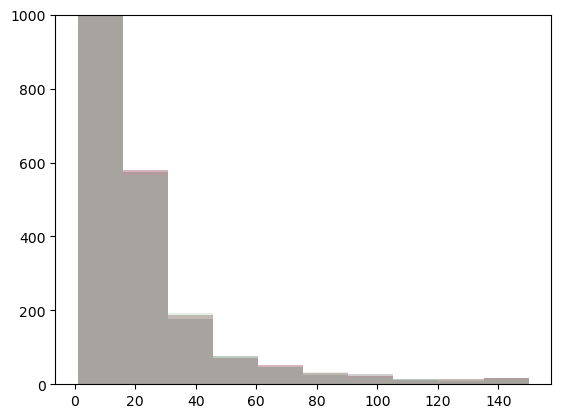

In [161]:
# Optional: Define a list of colors if you want specific colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
color_idx = 0

for fn in glob.glob(os.path.join(base_dir, 'labels/testing*')):
    with btrack.io.HDF5FileHandler(fn, 'r', obj_type='obj_type_1') as reader:
        tracks = reader.tracks

    # Plotting with varying colors and transparency
    plt.hist([len(track) for track in tracks], color=colors[color_idx % len(colors)], alpha=0.1)

    # Increment color index for next iteration
    color_idx += 1

# Set y-axis limit
plt.ylim(0, 1000)

# Display the plot
plt.show()

# Trying two channel segmentation

In [43]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# model = models.Cellpose(gpu=True, model_type='cyto')
model_path = '/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/models/models/macrohet_seg'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)
def segment(img, diameter = 30, channels = [0,0]):
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels,
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Jan  4 15:27:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:65:00.0  On |                  Off |
| 30%   47C    P8              35W / 300W |   3352MiB / 49140MiB |      0%      D

INFO:cellpose.core:** TORCH CUDA version installed and working. **


>>> GPU activated? YES


INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [36]:
img = images[0]

In [37]:
img.shape

(2, 6048, 6048)

In [44]:
masks = segment(img, diameter = None)

ValueError: not enough values to unpack (expected 4, got 3)

In [57]:
model = models.Cellpose(gpu=True, model_type='cyto')
output = model.eval(img, diameter = 300)#, diameter=diameter, channels=channels,
                                             # flow_threshold=None, cellprob_threshold=0)

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 112.45 sec


In [58]:
output[0].shape
masks = output[0]

In [59]:
viewer.add_labels(masks)

<Labels layer 'masks [3]' at 0x7effa00f3d90>

In [48]:
print()

In [72]:
img

dask.array<getitem, shape=(2, 6048, 6048), dtype=uint16, chunksize=(2, 2160, 2160), chunktype=numpy.ndarray>

# Trying a new segmentation approach

In [69]:
import torch
print(torch.__version__)

2.1.1+cu121


In [71]:
from segment_anything import SamPredictor, sam_model_registry


ModuleNotFoundError: No module named 'torchvision.ops'

In [77]:
import numpy as np

In [78]:
np.save('t0_ND2.npy', cut_images[0])